In [73]:
import pandas as pd
import numpy as np
import csv 
import random
import math
import matplotlib.pyplot as plt

In [74]:
#Getting the data 
data_array = np.genfromtxt("cm_dataset_2 - cm_dataset.csv" , dtype = 'float64',delimiter=',',)
#Number of data points
Num_of_data_points = data_array.shape[0]
#Dimension of each data point
Dimension_of_data_point = data_array.shape[1]
#initialising the cluster
Cluster_type = np.full((Num_of_data_points) , 0)


In [75]:
def Kernal_Matrix_Func(data_array , type , Variance_or_Power_of_Polynomial , Num_of_data_points):
    Kernal_Matrix = np.full((Num_of_data_points , Num_of_data_points), 0.00 , dtype= 'float64')
    #Polynomial Kernal
    if type == 0 :
        Kernal_Matrix = (np.full((Num_of_data_points,Num_of_data_points) , 1.0 , dtype='float64') + np.matmul(data_array , data_array.transpose()))**Variance_or_Power_of_Polynomial
    #Radial Kernal 
    if type == 1 :
        for i in range(Num_of_data_points):
            for j in range(Num_of_data_points):
                Kernal_Matrix[i][j] = math.exp((-1 * np.sum(np.square(data_array[i] - data_array[j])))/(2*Variance_or_Power_of_Polynomial*Variance_or_Power_of_Polynomial))
        #Finding mean transpose dot mean and filling a matrix n*n with it's values 
    Mean_transpose_dot_Mean = np.sum(Kernal_Matrix) / (Num_of_data_points**2)
    Mean_transpose_dot_Mean_Matrix = np.full((Num_of_data_points,Num_of_data_points) , Mean_transpose_dot_Mean , dtype='float64')

    Row_Sum_Matrix = np.full((Num_of_data_points,Num_of_data_points) , 0.0 , dtype='float64')
    Column_Sum_Matrix = np.full((Num_of_data_points,Num_of_data_points) , 0.0 , dtype='float64')

    #Finding the sum of the rows divided by number of data points 
    for i in range(Num_of_data_points):
        Row_Sum_Matrix[i] = np.full(Num_of_data_points,np.sum(Kernal_Matrix[i]) ,dtype='float64')
    Row_Sum_Matrix /= Num_of_data_points
    
    #Finding the sum of the columns divided by number of data points 
    for j in range(Num_of_data_points):
        Column_Sum_Matrix[:,j] = np.full(Num_of_data_points,np.sum(Kernal_Matrix[:,j]) ,dtype='float64')
    Column_Sum_Matrix /= Num_of_data_points

    #Finding the Centralised Matrix 
    Kernal_Matrix_After_Centralised = Kernal_Matrix - Row_Sum_Matrix - Column_Sum_Matrix + Mean_transpose_dot_Mean_Matrix
    return Kernal_Matrix_After_Centralised

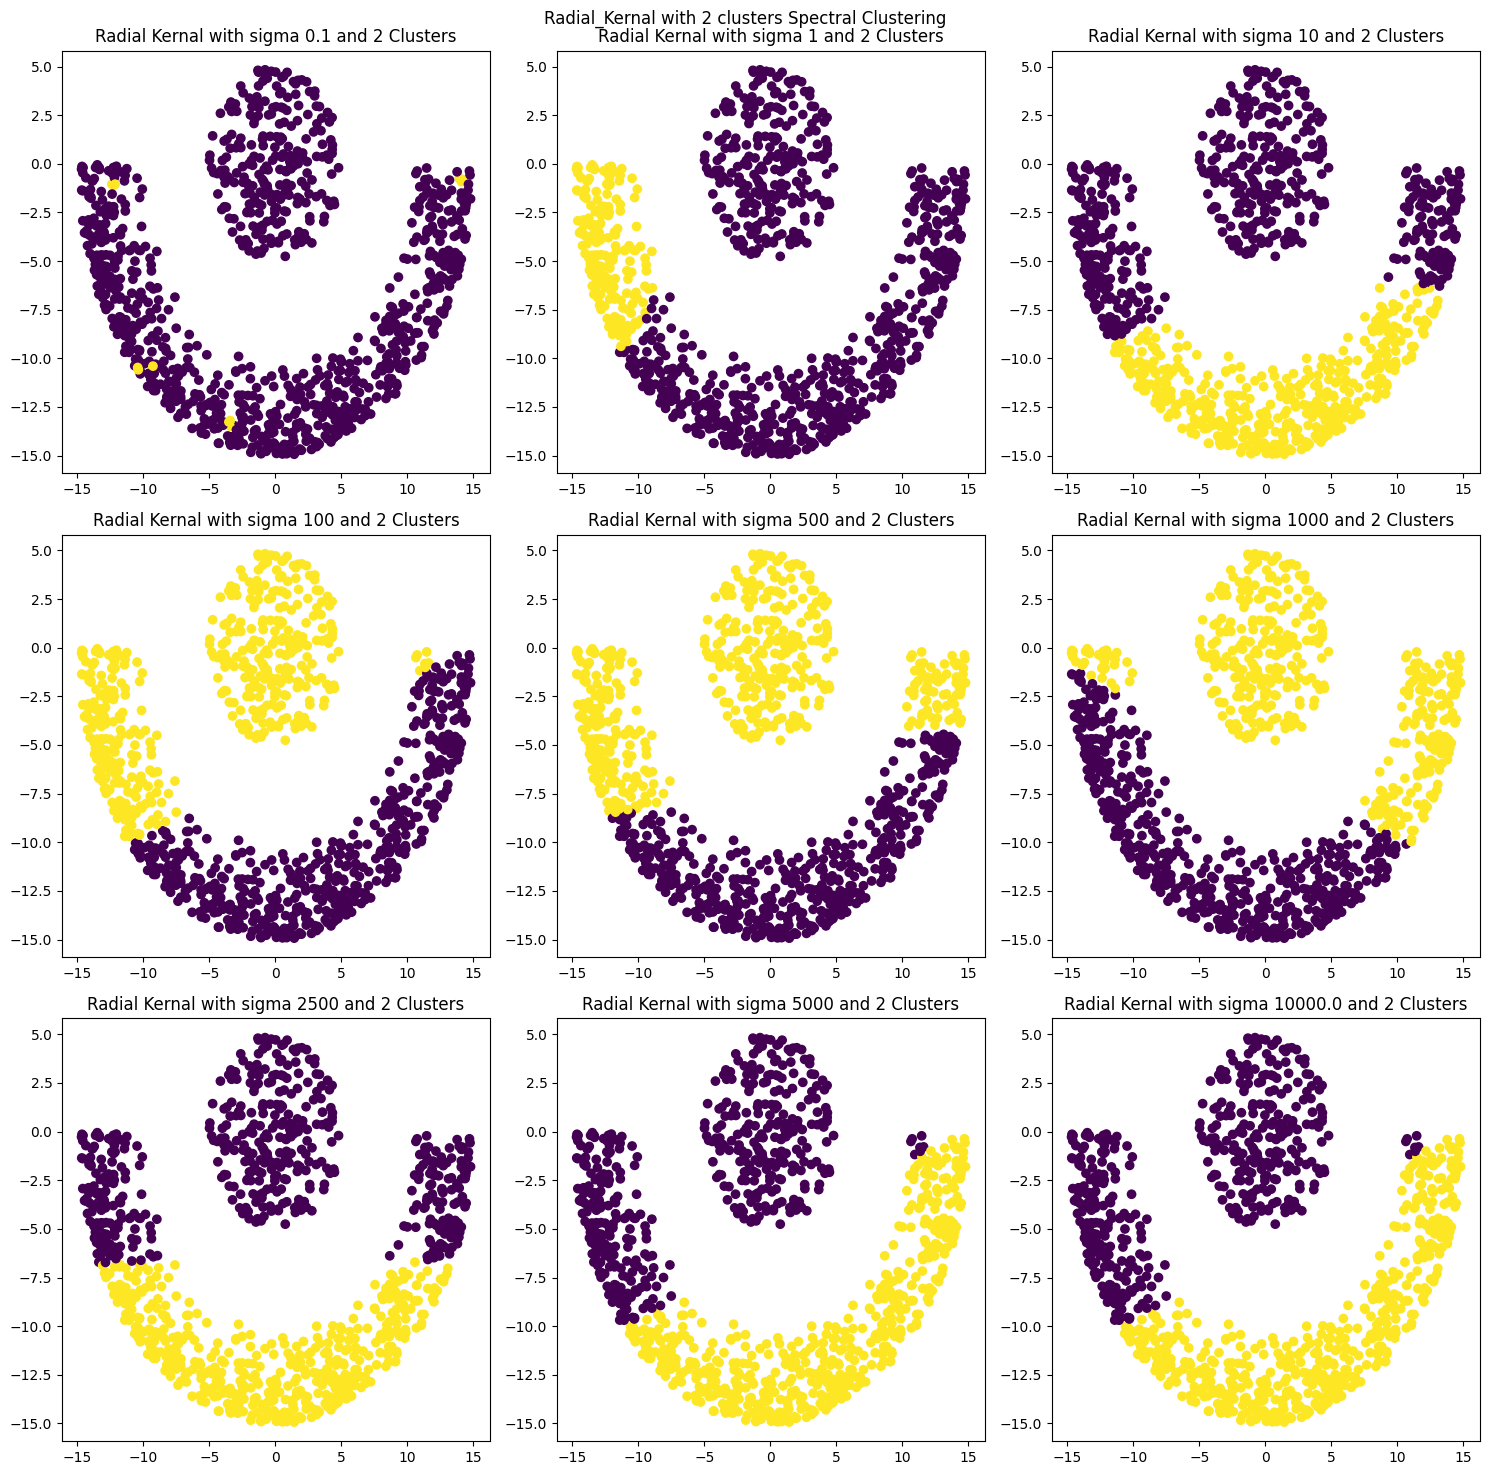

In [76]:
fig , axes = plt.subplots(3, 3 , figsize = (15 , 15))
'''#Change the following values for sigma or Power according to the kernal used '''
variance_or_Power = [0.1 , 1 , 10 , 100 , 500 ,1000 , 2500 , 5000 , 1e4]
for var in range(len(variance_or_Power)):
    Kernal_Matrix = np.full((Num_of_data_points , Num_of_data_points) ,0.00, dtype= 'float64')

    '''#Change the type to 0 for polynomial kernal and type 1 for Radial '''
    Kernal_Matrix = Kernal_Matrix_Func(data_array=data_array ,  type= 1 , Variance_or_Power_of_Polynomial= variance_or_Power[var] ,Num_of_data_points=Num_of_data_points)


    Kernal_Eigenvalues , Kernal_Eigenvectors = np.linalg.eigh(Kernal_Matrix)

    #Sorting eigenvectors in the descending orders of their respective eigenvalues
    Kernal_Eigenvectors = Kernal_Eigenvectors[:,np.flip(np.argsort(Kernal_Eigenvalues))]

    #Sorting the eigenvalues in descending order
    Kernal_Eigenvalues = Kernal_Eigenvalues[np.flip(np.argsort(Kernal_Eigenvalues))]
    #Change here for changing the number of clusters 
    Num_of_Components = 2
    Num_of_Clusters = Num_of_Components

    Top_Eigenvectors = np.full((Num_of_data_points,Num_of_Components),0.0,dtype = 'float64')

    #Finding the top K eigenvectors of the Kernal Matrix 
    for i in range(Num_of_Components):
        Top_Eigenvectors[:,i] = Kernal_Eigenvectors[:,i]

    #Row Normalization
    for i in range(Num_of_data_points):
         temp = math.sqrt(np.sum(np.square(Top_Eigenvectors[i])))
         Top_Eigenvectors[i] /= temp

    Mean_of_Clusters = np.full((Num_of_Clusters , Num_of_Components) , 0 , dtype='float64')
    Num_of_points_in_each_cluster = np.full((Num_of_Clusters), 0)

    #initialising the Clusters 
    for i in range(Num_of_data_points):
        Cluster_type[i] = random.randint(0,Num_of_Clusters-1)

    #Finding the mean and the number of points in each cluster
    for i  in range(Num_of_data_points):
            Mean_of_Clusters[Cluster_type[i]] += Top_Eigenvectors[i]
            Num_of_points_in_each_cluster[Cluster_type[i]] += 1
    for i in range(Num_of_Clusters):
            Mean_of_Clusters[i] /= Num_of_points_in_each_cluster[i]


    Prev_Cluster_type = np.full((Num_of_data_points) , 0)

    colormap = np.array([0.1 , 0.2 , 0.3 ,0.4 , 0.5])

    ##K-means 
    Error = []
    Num_of_iterations = 0
    while (True):
        #Error initialisation
        Error_in_ith_iteration = 0
        Prev_Cluster_type = Cluster_type.copy()
        Num_of_iterations += 1 

        for i in range(Num_of_data_points):
            #Finding the distance of i th point from all the clusters
            Distance_square_from_mean = np.full((Num_of_Clusters),0.0 , dtype= 'float64')
            for j in range(Num_of_Clusters):
                Distance_square_from_mean[j] = np.sum(np.square((Top_Eigenvectors[i] - Mean_of_Clusters[j]))) 

        #Finding the net error
            Error_in_ith_iteration += Distance_square_from_mean.min()
        #Assigning the cluster
            Cluster_type[i] = np.argmin(Distance_square_from_mean)
        Error.append(Error_in_ith_iteration)
    

        Mean_of_Clusters = np.full((Num_of_Clusters , Num_of_Components) , 0.0 , dtype='float64')
        Num_of_points_in_each_cluster = np.full((Num_of_Clusters), 0)

        #Find the mean of clusters and nuumber of points in each cluster
        for i  in range(Num_of_data_points):
            Mean_of_Clusters[Cluster_type[i]] += Top_Eigenvectors[i]
            Num_of_points_in_each_cluster[Cluster_type[i]] += 1
        for i in range(Num_of_Clusters):
            Mean_of_Clusters[i] /= Num_of_points_in_each_cluster[i]
        #The algorithm converges when the previous cluster assignement and the present cluster assignment are the same 
        if ((Prev_Cluster_type == Cluster_type).all()):
            break

    axes[var//3 , var % 3].scatter(data_array[:,0] , data_array[:,1], c = colormap[Cluster_type])

    '''#Change here for changing the naming of the kernal type and sigma or power'''
    axes[var//3 , var % 3].set_title(f"Radial Kernal with sigma {variance_or_Power[var]} and {Num_of_Clusters} Clusters")

fig.suptitle(f"Radial_Kernal with 2 clusters Spectral Clustering")
plt.tight_layout()
'''plt.savefig(f"Radial_Kernal with {Num_of_Clusters} clusters Spectral Clustering")'''
plt.show()
